## Імпорт бібліотек

In [1]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.image import resize
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import skimage
import cv2
import os
import re
from PIL import Image

## Тестові фото

In [2]:
dir_path = r'C:\Users\kuzik\Desktop\png'
list_files = os.listdir(dir_path)
list_files
files  = []
for filename in list_files:
    if filename != 'desktop.ini':
        files.append(re.sub(r'\\', r'/', dir_path + "/" + filename))

In [3]:
# train_datagen = ImageDataGenerator(rescale=1./255)

# photo_generator = train_datagen.flow_from_directory(
#     r'C:\Users\kuzik\Desktop\ext',
#     target_size=(32, 32),
#     classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
#     batch_size=700,
#     class_mode="binary"
# )
# y_photo_generator = photo_generator[0][1]

# y = []
# i = 1
# for el in y_photo_generator:
#     classes_array = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#     classes_array[int(el)] = 1
#     y.append(classes_array)
#     i += 1
        
# y = np.array(y, dtype=np.float32)

# x, y = photo_generator[0][0], y

## Функція обробки фото і передбачення

In [4]:
def img_preproces(img, expand_dims = False, copy = False, preprocess_img = False):
    if expand_dims == True:
        img = np.expand_dims(img, axis=0)
    if copy == True:
        img = np.copy(img)
    if preprocess_img == True:
        img = preprocess_input(img).astype("float32") / 255
    return img

def tf_resize(img):
    img = resize(img, (32, 32))
    img = img_to_array(img)
    img = img_preproces(img, expand_dims = True, copy = True, preprocess_img = True)
    return img

def cv2_resize(img):
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
    img = img_preproces(img, expand_dims = True, copy = True, preprocess_img = True)
    return img

def si_resize(img):
    img = skimage.transform.resize(img, (32, 32, 3), anti_aliasing=True)
    img = img_preproces(img, expand_dims = True)
    return img

def pillow_resize(img):
    img = Image.open(img)
    img = img.resize((32, 32))
    img = img_preproces(img, expand_dims = True, copy = True, preprocess_img = True)
    return img
    

def si_rescale(img):
    for_rescale = list(img.shape)
    for_rescale.sort()
    scale_rating = 32 / for_rescale[1]
    img = skimage.transform.rescale(skimage.transform.resize(img, (for_rescale[1], for_rescale[1]), 3), scale_rating, multichannel=True)
    img = img_preproces(img, expand_dims = True)
    return img

def image_classify(filename, processor, model):
    print(filename)
    if processor == 'tf':
        img = load_img(filename)
        img = tf_resize(img)
    elif processor == 'cv2':
        img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        img = cv2_resize(img)
    elif processor == 'si_resize':
        img = skimage.io.imread(filename)
        img = si_resize(img)
    elif processor == 'si_rescale':
        img = skimage.io.imread(filename)
        img = si_rescale(img)
    elif processor == 'pillow':
        img = pillow_resize(filename)
    
    features = model.predict(img)
    top = []
    top_num = 3
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for request in range(1):  # num of foto or objects on foto
        classes_request = classes
        features_request = features[0]
        rang = 1
        for i in range(top_num):
            pred = np.argmax(features_request)
            top.append([rang, classes_request[pred], round(features_request[np.argmax(features_request)], 4)])
            features_request = np.delete(features_request, np.argmax(features_request))
            classes_request.remove(classes_request[pred])
            rang +=1
    return top

## Перевірка роботи моделі з стисканням від tensorflow та cv2

In [22]:
def obj_on_file(file):
    file_name = file.split("/")[-1]
    file_name = file_name.split(".")[0:-1]
    find = re.match(r'\D+', str(file_name)).group()[2:]
    return find

def testing(path, processor, model, print_result = False):
    result = []
    obj = []
    for file in path:
        o = obj_on_file(file)
        predict_img = image_classify(file, processor, model = model)
        obj.append(o)
        result.append(predict_img[0][1])
        
        if print_result == True:
            print("")
            print("Must be: ", obj)
            print(predict_img)
        
    return result, obj

def data_for_matrics(row, column):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    x = np.zeros((10, 10))
    for pred, answer in zip(row, column):
        x[classes.index(answer)][classes.index(pred)] +=1
    return x

def accuracy_of_model(path, processor, model, print_result=False, make_matrix=False):
    result_test, answer_test = testing(path = path, processor = processor, model = model, print_result = print_result)
    list_of_results = []
    for num in range(len(result_test)):
        if result_test[num] == answer_test[num]:
            list_of_results.append(1)
        else:
            list_of_results.append(0)
    
    if make_matrix == True:
        matrix_data = data_for_matrics(row=result_test, column=answer_test)
        return list_of_results, matrix_data
    return list_of_results
    

def compare_processors(path, model, processor=[], print_result=False, make_matrix=False):
    result = []
    for el in processor:
        if make_matrix:
            model_accuracy, accuracy_matrix = accuracy_of_model(path, model = model, processor = el, print_result = print_result, make_matrix = make_matrix)
        else:
            model_accuracy = accuracy_of_model(path, model = model, processor = el, print_result = print_result, make_matrix = make_matrix)
        accuracy_percent = model_accuracy.count(1) / len(model_accuracy) * 100
        result.append(f'Using {el} for resize photo, prediction accuracy of your photo set is: {accuracy_percent} %')
    if make_matrix:
        return result, accuracy_matrix
    return result

## Завантаження моделі

In [34]:
# model = load_model("C:/Users/kuzik/Desktop/project3/models/model_from_Susana_v2.h5")
# model.load_weights("C:/Users/kuzik/Desktop/project3/models/weights_from_Susana_v2.h5")

model1_1 = load_model("C:/Users/kuzik/Desktop/project3/models/model_from_Susana.h5")
# model1_1.load_weights("C:/Users/kuzik/Desktop/project3/models/weights_from_Susana.h5")

# model2 = load_model("C:/Users/kuzik/Desktop/project3/models/model_from_mentor.h5")
# model2.load_weights("C:/Users/kuzik/Desktop/project3/models/weights_from_mentor.h5")

# model3 = load_model("C:/Users/kuzik/Desktop/project3/models/base_model.h5")
# model3.load_weights("C:/Users/kuzik/Desktop/project3/models/weights_base_model.h5")

model4 = load_model("C:/Users/kuzik/Desktop/project3/models/model_from_Susana_v3.h5")
# model4.load_weights("C:/Users/kuzik/Desktop/project3/models/weights_from_Susana_v3.h5")

# model5 = load_model("C:/Users/kuzik/Desktop/project3/models/model_from_mentor_v2.h5")
# model5.load_weights("C:/Users/kuzik/Desktop/project3/models/weights_from_mentor_v2.h5")

# model6 = load_model("C:/Users/kuzik/Desktop/project3/models/model_from_mentor_v3.h5")
# model6.load_weights("C:/Users/kuzik/Desktop/project3/models/weights_from_mentor_v3.h5")

# model7 = load_model("C:/Users/kuzik/Desktop/project3/models/model_from_Susana_v4.h5")
# model7.load_weights("C:/Users/kuzik/Desktop/project3/models/weights_from_Susana_v4.h5")

# model8 = load_model("C:/Users/kuzik/Desktop/3/ImageClassifier/model1.h5", custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m})

In [35]:
# s = compare_processors(path=files, processor=['tf', 'cv2', 'si_resize', 'pillow'], model=model) # 'tf', 'cv2','si_resize','si_rescale'
# s_1, m = compare_processors(path=files, processor=['si_resize'], model=model1_1, make_matrix = True) # 'si_rescale'
# m = compare_processors(path=files, processor=['tf', 'cv2', 'si_resize', 'pillow'], model=model2) # 'si_rescale'
# b = compare_processors(path=files, processor=['tf', 'cv2', 'si_resize', 'pillow'], model=model3) # 'si_rescale'
s_3 = compare_processors(path=files, processor=['si_resize'], model=model4, make_matrix = True) # 'si_rescale'
# m_2 = compare_processors(path=files, processor=['tf', 'cv2', 'si_resize', 'pillow'], model=model5) # 'si_rescale'
# m_3 = compare_processors(path=files, processor=['tf', 'cv2', 'si_resize', 'pillow'], model=model6) # 'si_rescale'
# s_4, m = compare_processors(path=files, processor=['si_resize'], model=model7, make_matrix = True)
# u = compare_processors(path=files, processor=['tf', 'cv2', 'si_resize', 'pillow'], model=model8) # 'si_rescale'

C:/Users/kuzik/Desktop/png/airplane1.jpeg
1/1 [==============================] - 1s 1s/step
C:/Users/kuzik/Desktop/png/airplane10.jpg
1/1 [==============================] - 0s 29ms/step
C:/Users/kuzik/Desktop/png/airplane11.jpg
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/airplane12.jpg
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/airplane13.jpg
1/1 [==============================] - 0s 30ms/step
C:/Users/kuzik/Desktop/png/airplane14.jpg
1/1 [==============================] - 0s 32ms/step
C:/Users/kuzik/Desktop/png/airplane15.jpg
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/airplane16.jpg
1/1 [==============================] - 0s 30ms/step
C:/Users/kuzik/Desktop/png/airplane17.jpg
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/airplane18.jpg
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/airplane19.jpg
1/1 [===============

1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/automobile25.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/automobile26.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/automobile27.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/automobile28.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/automobile29.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/automobile3.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/automobile30.jpg
1/1 [==============================] - 0s 29ms/step
C:/Users/kuzik/Desktop/png/automobile31.jpg
1/1 [==============================] - 0s 34ms/step
C:/Users/kuzik/Desktop/png/automobile32.jpg
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/automobile33.jpg
1/1 [==============================] - 0s

1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/bird42.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/bird43.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/bird44.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/bird45.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/bird46.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/bird47.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/bird48.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/bird49.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/bird5.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/bird50.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/bird51.png
1/1 [======

1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/cat60.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/cat61.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/cat62.png
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/cat63.png
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/cat64.png
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/cat65.png
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/cat66.png
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/cat67.png
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/cat68.png
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/cat69.png
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/cat7.jpg
1/1 [=================

1/1 [==============================] - 0s 29ms/step
C:/Users/kuzik/Desktop/png/dog17.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/dog18.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/dog19.jpg
1/1 [==============================] - 0s 29ms/step
C:/Users/kuzik/Desktop/png/dog2.jpg
1/1 [==============================] - 0s 29ms/step
C:/Users/kuzik/Desktop/png/dog20.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/dog21.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/dog22.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/dog23.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/dog24.jpg
1/1 [==============================] - 0s 29ms/step
C:/Users/kuzik/Desktop/png/dog25.jpg
1/1 [==============================] - 0s 29ms/step
C:/Users/kuzik/Desktop/png/dog26.jpg
1/1 [=================

1/1 [==============================] - 0s 25ms/step
C:/Users/kuzik/Desktop/png/frog39.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/frog4.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/frog40.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/frog41.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/frog42.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/frog43.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/frog44.jpg
1/1 [==============================] - 0s 25ms/step
C:/Users/kuzik/Desktop/png/frog45.jpg
1/1 [==============================] - 0s 25ms/step
C:/Users/kuzik/Desktop/png/frog46.jpg
1/1 [==============================] - 0s 25ms/step
C:/Users/kuzik/Desktop/png/frog47.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/frog48.jpg
1/1 [======

1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/horse50.jpg
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/horse51.png
1/1 [==============================] - 0s 34ms/step
C:/Users/kuzik/Desktop/png/horse52.png
1/1 [==============================] - 0s 34ms/step
C:/Users/kuzik/Desktop/png/horse53.png
1/1 [==============================] - 0s 32ms/step
C:/Users/kuzik/Desktop/png/horse54.png
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/horse55.png
1/1 [==============================] - 0s 31ms/step
C:/Users/kuzik/Desktop/png/horse56.png
1/1 [==============================] - 0s 30ms/step
C:/Users/kuzik/Desktop/png/horse57.png
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/horse58.png
1/1 [==============================] - 0s 30ms/step
C:/Users/kuzik/Desktop/png/horse59.png
1/1 [==============================] - 0s 30ms/step
C:/Users/kuzik/Desktop/png/horse6.jpg


1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/ship8.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/ship9.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/truck1.jfif
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/truck10.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/truck11.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/truck12.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/kuzik/Desktop/png/truck13.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/truck14.jpg
1/1 [==============================] - 0s 27ms/step
C:/Users/kuzik/Desktop/png/truck15.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/truck16.jpg
1/1 [==============================] - 0s 26ms/step
C:/Users/kuzik/Desktop/png/truck17.jpg
1/1

# Test on files .png

## Susana's model

In [48]:
 for el in s_1:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 25.0 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 61.36363636363637 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 57.27272727272727 %


In [43]:
for el in s:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 24.09090909090909 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 58.63636363636363 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 67.27272727272727 %


In [7]:
for el in s_3:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 43.18181818181818 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 67.56198347107438 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 76.65289256198346 %
Using pillow for resize photo, prediction accuracy of your photo set is: 60.74380165289256 %


In [11]:
for el in s_4:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 24.380165289256198 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 58.88429752066116 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 78.71900826446281 %
Using pillow for resize photo, prediction accuracy of your photo set is: 53.71900826446281 %


## Ulyana's model

In [9]:
for el in u:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 35.12396694214876 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 55.16528925619835 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 71.07438016528926 %
Using pillow for resize photo, prediction accuracy of your photo set is: 48.34710743801653 %


## Mentor's Model

In [7]:
for el in m:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 33.47107438016529 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 48.553719008264466 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 45.04132231404959 %
Using pillow for resize photo, prediction accuracy of your photo set is: 42.768595041322314 %


In [8]:
for el in m_2:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 24.380165289256198 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 22.31404958677686 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 64.25619834710744 %
Using pillow for resize photo, prediction accuracy of your photo set is: 25.0 %


In [8]:
for el in m_3:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 15.082644628099173 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 16.94214876033058 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 60.9504132231405 %
Using pillow for resize photo, prediction accuracy of your photo set is: 18.388429752066116 %


## Base Model

In [45]:
for el in b:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 42.72727272727273 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 48.63636363636364 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 42.27272727272727 %


# Test on oll files

## Susana's model

In [17]:
for el in s_1:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 46.48760330578512 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 64.0495867768595 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 75.41322314049587 %
Using pillow for resize photo, prediction accuracy of your photo set is: 60.12396694214877 %


In [18]:
for el in s:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 47.31404958677686 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 68.18181818181817 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 78.92561983471074 %
Using pillow for resize photo, prediction accuracy of your photo set is: 65.08264462809917 %


## Mentor's Model

In [19]:
for el in m:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 33.47107438016529 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 48.553719008264466 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 45.04132231404959 %
Using pillow for resize photo, prediction accuracy of your photo set is: 42.768595041322314 %


## Base Model

In [20]:
for el in b:
    print(el)

Using tf for resize photo, prediction accuracy of your photo set is: 44.83471074380165 %
Using cv2 for resize photo, prediction accuracy of your photo set is: 57.231404958677686 %
Using si_resize for resize photo, prediction accuracy of your photo set is: 55.99173553719008 %
Using pillow for resize photo, prediction accuracy of your photo set is: 45.66115702479338 %


In [25]:
for el in s_4:
    print(el)

Using si_resize for resize photo, prediction accuracy of your photo set is: 70.98150782361309 %


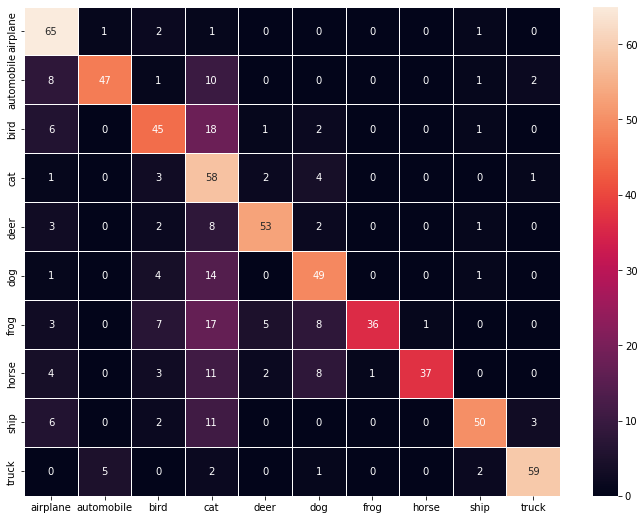

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12, 9))
ax = sns.heatmap(m, annot=True, fmt='g', linewidth=0.5)
ax.set(xticklabels=classes, yticklabels=classes)

plt.show()

In [31]:
for el in s_1:
    print(el)

Using si_resize for resize photo, prediction accuracy of your photo set is: 69.84352773826458 %


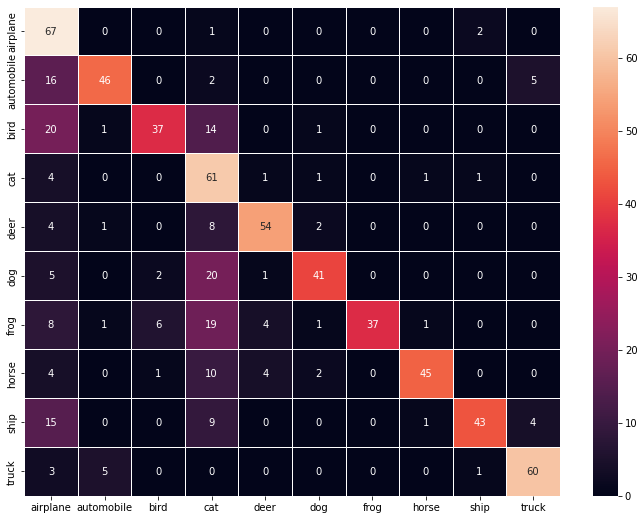

In [32]:
plt.figure(figsize=(12, 9))
ax = sns.heatmap(m, annot=True, fmt='g', linewidth=0.5)
ax.set(xticklabels=classes, yticklabels=classes)

plt.show()

In [36]:
for el in s_3:
    print(el)

['Using si_resize for resize photo, prediction accuracy of your photo set is: 70.27027027027027 %']
[[68.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [12. 47.  1.  3.  0.  0.  1.  1.  0.  4.]
 [21.  1. 42.  2.  0.  4.  2.  0.  1.  0.]
 [ 5.  0.  1. 47.  2. 10.  0.  0.  2.  2.]
 [10.  0.  0.  7. 46.  2.  1.  2.  0.  1.]
 [ 4.  0.  1. 14.  1. 47.  0.  1.  1.  0.]
 [14.  0.  7. 10.  2.  2. 41.  0.  0.  1.]
 [ 5.  0.  1.  5.  1.  6.  5. 43.  0.  0.]
 [12.  0.  0.  5.  1.  0.  1.  1. 51.  1.]
 [ 1.  5.  0.  0.  0.  0.  0.  0.  1. 62.]]


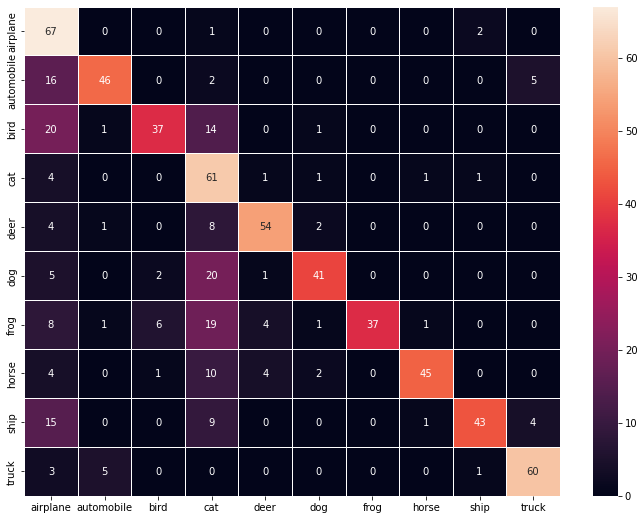

In [37]:
plt.figure(figsize=(12, 9))
ax = sns.heatmap(m, annot=True, fmt='g', linewidth=0.5)
ax.set(xticklabels=classes, yticklabels=classes)

plt.show()